<a href="https://colab.research.google.com/github/yvesheri4/short-pulse-electron-beam-python/blob/main/Particle_motion_energyplots_5_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Paper 1 - Space charge effects

____

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import joypy
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from sklearn.datasets import load_iris
import os
import pandas as pd
from glob import glob
import seaborn as sns

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import numpy as np
from matplotlib.ticker import MaxNLocator

import warnings

# Filter out all warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import constants
import seaborn as sns
eps_0 = constants.epsilon_0
from matplotlib import cm
# import scienceplots
import matplotlib.pyplot as plt
import matplotlib as mpl

# plt.style.use(['no-latex'])

size = 24
params = {
   'axes.labelsize': size,
   'font.size': size,
   'legend.fontsize': size,
   'xtick.labelsize': size,
   'ytick.labelsize': size,
   'text.usetex': False,
   'axes.linewidth':2.75,
   'figure.figsize': [4.5, 4.5]
   }
plt.rcParams.update(params)

### Particles

In [ ]:
import numpy as np
from scipy import constants as cst

# Define the particle class
class Particle:
    def __init__(self, mass,charge, index):
        self.mass = mass
        self.i = index
        self.charge = charge
        self.r = np.zeros((1), dtype='float64')
        self.v = np.zeros((1), dtype='float64')

    def initPos(self, x):
        self.r = x

    def initSpeed(self, vx):
        self.v = vx

    def Heri_push(self, dt, E):
        temp = self.v
        self.v += 1.5*E*dt
        self.r += 3*(self.v+temp)*dt/2

### Functions

#### Particles related functions

In [ ]:
def Create_Particle_list(mass,charge):
    List = []
    for i in range(len(charge)):
        List.append(Particle(mass[i],charge[i],i+1))
    return List

def Init_Particle_list(List,InitPos,InitSpeed):
    for i in range(len(List)):
        List[i].initPos(InitPos[i])
        List[i].initSpeed(InitSpeed[i])
    return List


#### Fields related functions

In [ ]:
def Electric_Field(List,V0,d,t,Dt):
    N_inj = 1+int(t/Dt)
    if N_inj > len(List):
        N_inj = len(List)
    E = np.zeros(len(List))
    sum1 = 0
    List2 = []
    for j in range(N_inj):
        if List[j].r < 1 and List[j].r >=0:
            sum1 += (List[j].charge*List[j].r)
            List2.append(List[j])
    for j in range(len(List2)):
        sum2 = 0
        for i in range(j):
            sum2 += List2[i].charge
        E[List2[j].i-1] = 1 + (sum1 - sum2 + 0.5*List2[j].charge)
    return E

def Current_density(Vel,rho):

    len_t = Vel.shape[0]
    N_sheet = Vel.shape[1]
    J = np.zeros(len_t)

    for i in range(len_t):
        sum1 = 0
        for j in range(N_sheet):
            sum1 += 3*Vel[i][j]*rho[j]
        J[i] = sum1

    return J

#### Simulations related

In [ ]:
def Simulation(t_sim,Sys_Params,InitCond,k=100):

    time = np.linspace(0,t_sim,k)
    dt = time[1]-time[0]

    InitPos,InitSpeed = InitCond
    Dt,mass,charge,V0,d = Sys_Params

    List_part = Create_Particle_list(mass,charge)

    List_part = Init_Particle_list(List_part,InitPos,InitSpeed)
#     print(List_part[0].r)

    position = np.zeros([len(time),len(List_part)])
    velocity = np.zeros([len(time),len(List_part)])
    E_field = np.zeros([len(time),len(List_part)])

    count = 0

    for t in time:
        E = Electric_Field(List_part,V0,d,t,Dt)
        E_field[count] = E

        for j in range(len(List_part)):
            position[count][j] = List_part[j].r
            velocity[count][j] = List_part[j].v

            if List_part[j].r < 1 and List_part[j].r >= 0:
                List_part[j].Heri_push(dt,E[j])
            else:
                List_part[j].v = 0
        count += 1
    return position,velocity,E_field

def distorsion(position,time,Dt,M):
    t_init = Dt*(M-1)
    i = 0
    while  position[i,0] < 1:
        i +=1
    j = 0
    while  position[j,-1] < 1:
        j +=1
    t_final = time[j] - time[i]
    Distorsion = t_final / t_init
    return Distorsion

def Norm_J_crit_s(Xcl):
    return (3/4)/Xcl

def Norm_J_crit_e(Xcl):
    T1 = 2*(1-np.sqrt(1-(3/4)*Xcl**2))/Xcl**3
    return T1

def limit_charge(T0,Params_sys,ini_conds,iterations):
    tol = 1e-7
    Indicator = False
    position,velocity,E_field = Simulation(T0,Params_sys,ini_conds,iterations)
    if (position[-1,:] - position[0,:] < tol ).any():
    # if abs(position[-1,-1] - position[0,-1]) < tol  :
#     if (position[-1,-1] - position[0,-1] < tol ) :
        Indicator = True
    return Indicator

# def sheets_spacing(mass,) = lambda e,E,m,dt: 0.5*(e*E/m)*(dt**2)

Time_transit = lambda Vg,d : np.sqrt(2*d/(cst.e*Vg/(d*cst.m_e)))

Sigma_1 = lambda Vg,d : -cst.epsilon_0*Vg/d

#### Plots

In [ ]:
def plots_shape_phase_mult(position,velocity,E_field,rho,n=2):

#     lag = int(len(position[0])/n)

    lag = 5000

    len_rho = len(rho)

    psum = [6.2665706768411304,12.499856013286099,17.94732608456735,21.721125396120463]

    for i in range(1,n+2):
        if i == n:
            lag = lag - 1

        plt.figure(figsize=(10,2.75))

#         print(i*lag*Dt_b*Tcl/T0)


        for j in range(len_rho):

            shape = np.array([position[j][lag*i],rho[j]])
            field = np.array([position[j][lag*i],E_field[j][lag*i]])
            phase = np.array([position[j][lag*i],velocity[j][lag*i]])

            plt.subplot(1,3,1)
            plt.title("Pulse profile")
            plt.plot(shape[0],shape[1],lw=1,label=f"$\\rho/\\rho^*$ = {int(100*(j+1)*0.25)}%")
#             plt.plot(shape[0],shape[1],lw=5,label=f"a = {round(1/psum[j],2)}, b= {2*((j+1)*2.5)**2}")

#             plt.xlabel("Position")
            plt.ylabel("Charge")
            plt.legend(fontsize=8)
            plt.xlim(0,1)
        ######################################################


            K = np.array([0])
            A = np.array([1])
            E_K = np.array([field[1][-1]])
            E_A = np.array([field[1][0]])
            con1 = np.concatenate((A, field[0],K))
            con2 = np.concatenate((E_A, field[1],E_K))

            plt.subplot(1,3,2)
            plt.title("E field")
#             plt.plot(field[0],field[1],lw=3)
            plt.plot(con1,con2,lw=1)
#             plt.xlabel("Position")
            plt.ylabel("E")
            plt.xlim(0,1)

        ######################################################

            plt.subplot(1,3,3)
            plt.title("Phase-space profile")
            plt.plot(phase[0],phase[1],lw=1)
#             plt.xlabel("Position")
            plt.ylabel("Velocity")
            plt.xlim(0,1)

            plt.tight_layout(pad=.3)

#         plt.savefig(f'snapshots_sq{j}.jpg', dpi=400)
        plt.show()

In [ ]:
# position_sq.shape

____

In [ ]:
def gaussian_profile(tp,M):
  sig2 = tp **2/np.log(256)
  sig = np.sqrt(sig2)
  t = np.linspace(-3.5*sig, 3.5*sig, M)
  prof_ = np.exp(-0.5*((t)**2) /sig2 )
  prof_ /= np.sum(prof_)
  return prof_

def trapezoid_profile(tp,M):
  start_time = 0
  rise_time = 0.15*tp
  fall_time = 0.15*tp

  # End time of the trapezoidal pulse
  end_time = start_time + rise_time + tp + fall_time

  t = np.linspace(0, end_time, M)

  # Initialize the pulse array
  pulse = np.zeros_like(t)

  # Calculate indices for rise, top, and fall segments
  rise_end = start_time + rise_time
  top_end = rise_end + tp
  fall_start = top_end
  fall_end = fall_start + fall_time

  # Rise segment
  pulse[(t >= start_time) & (t < rise_end)] = (
       (t[(t >= start_time) & (t < rise_end)] - start_time) / rise_time
  )
  # Top segment (FWHM width)
  pulse[(t >= rise_end) & (t < top_end)] = 1

  # Fall segment
  pulse[(t >= fall_start) & (t < fall_end)] = (
       (1 - ((t[(t >= fall_start) & (t < fall_end)] - fall_start) / fall_time))
  )
  return pulse / np.sum(pulse)

Time_CL = lambda Vg,d : 3*d/np.sqrt(2*cst.e*Vg/cst.m_e)

def pulse_profile(tp,M,Type = 'square'):
    Type = Type.lower()
    if Type == 'square':
        return np.ones(M)/M
    if Type == 'gauss':
        return gaussian_profile(tp,M)
    if Type == 'trapezoidal':
        return trapezoid_profile(tp,M)
    else:
        return print('Profile not recognized')

# Injection Simulation

## Parameters

In [ ]:
V0 = 30e3
d = 1.5e-3
M = 350
Tcl = Time_CL(V0,d)
kp = .1
fp = 1
tpulse = kp*Tcl     # Full Width at Half Maximum
t0 = tpulse/2       # Center of the pulse

iterations = 2000
Dt = kp/M

ini_pos = np.zeros(M)
ini_speed = np.zeros(M)
ini_conds = [ini_pos,ini_speed]
time = np.linspace(0, 2,iterations)

In [ ]:
#_______________________________
plt.rc('font', family='serif')
Ga_charge = pulse_profile(tpulse,M,Type = 'gauss')
color_ga = fp*Ga_charge
norm = mpl.colors.Normalize(vmin=color_ga.min(), vmax=color_ga.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])

## 1. Trajectories

### 1.1 Square-top

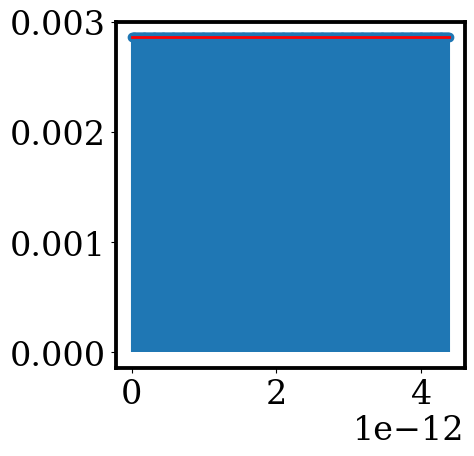

In [ ]:
Sq_charge = pulse_profile(tpulse,M)
Sq_mass = pulse_profile(tpulse,M)
t = np.linspace(0,tpulse,M)
plt.stem(t,Sq_charge, basefmt=" ", use_line_collection=True)
plt.plot(t,Sq_mass,'r',lw=2)

Sq_Params_sys = [Dt,fp*Sq_mass,fp*Sq_charge,V0,d]

### 1.2 Trapezoidal

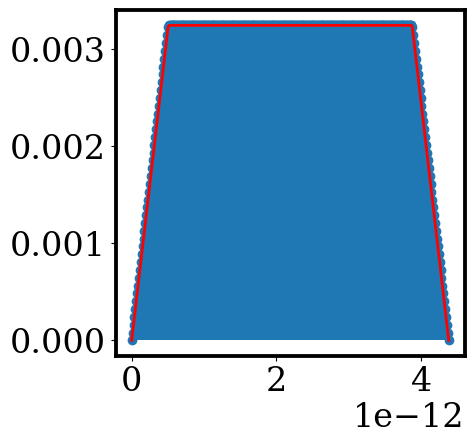

In [ ]:
Tr_charge = pulse_profile(tpulse,M,Type = 'trapezoidal')
Tr_mass = pulse_profile(tpulse,M,Type = 'trapezoidal')
t = np.linspace(0,tpulse,M)
plt.stem(t,Tr_charge, basefmt=" ", use_line_collection=True)
plt.plot(t,Tr_mass,'r',lw=2)

Tr_Params_sys = [Dt,fp*Tr_mass,fp*Tr_charge,V0,d]

### 1.3 Gaussian

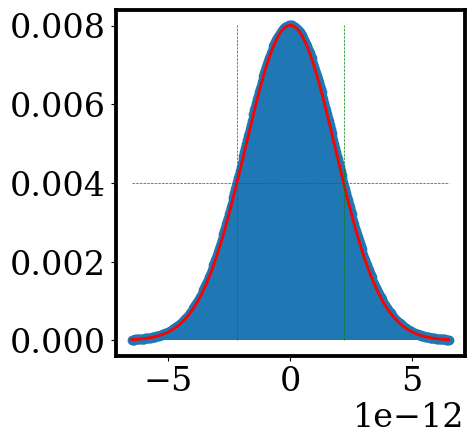

In [ ]:
Ga_charge = pulse_profile(tpulse,M,Type = 'gauss')
Ga_mass = pulse_profile(tpulse,M,Type = 'gauss')
sig2 = tpulse **2/np.log(256)
sig = np.sqrt(sig2)
t = np.linspace(-3.5*sig, 3.5*sig, M)
plt.stem(t,Ga_charge, basefmt=" ", use_line_collection=True)
plt.plot(t,Ga_mass,'r',lw=2)
plt.vlines(-tpulse/2, 0, max(Ga_mass), 'g','--',lw=0.5)
plt.vlines(tpulse/2, 0, max(Ga_mass), 'g','--',lw=0.5)
plt.hlines(max(Ga_mass)/2, -3.5*sig,3.5*sig, 'g','--',lw=0.5)

Ga_Params_sys = [Dt,fp*Ga_mass,fp*Ga_charge,V0,d]

In [ ]:
time[1850]

1.8509254627313656

## Energy distribution

In [ ]:
charge_mult = []
mass_mult = []
charge_mult.append(fp*Sq_charge)
charge_mult.append(fp*Tr_charge)
charge_mult.append(fp*Ga_charge)
mass_mult.append(fp*Sq_mass)
mass_mult.append(fp*Tr_mass)
mass_mult.append(fp*Ga_mass)

## k = 0.1

In [ ]:
fp = 1
kp = .1
Dt = kp/M

In [ ]:
position_mult = []
velocity_mult = []
E_field_mult = []
for i in range(3):
    Mass  = mass_mult[i]
    Charge = charge_mult[i]
    Params_sys = [Dt,Mass,Charge,V0,d]
    res_ = Simulation(2,Params_sys,ini_conds,iterations)
    position_mult.append(res_[0])
    velocity_mult.append(res_[1])
    E_field_mult.append(res_[2])

### at t = $2T_0$

In [ ]:
pos_ = [1]
EnK_01 = []
timeA = []

for v in range(3):  # Loop over v values 0, 1, 2
    K = []
    for p in pos_:
        for i in range(position_mult[v].shape[1]):
            for j in range(1950):
                if position_mult[v][j][i] >= p:
                    K.append( velocity_mult[v][j][i] ** 2)
                    break
    EnK_01.append(K)

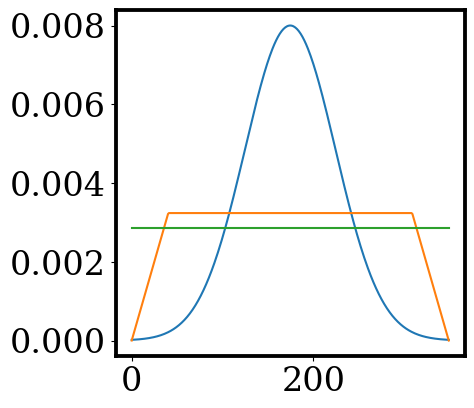

In [ ]:
plt.plot(mass_mult[2])
plt.plot(mass_mult[1])
plt.plot(mass_mult[0])

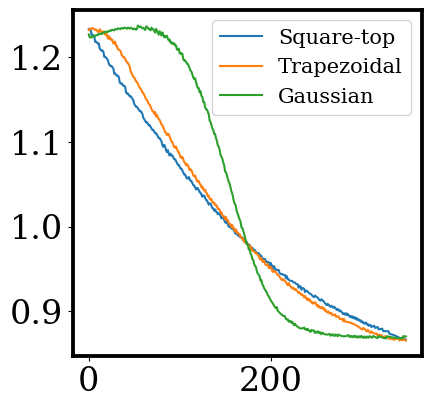

In [ ]:
plt.plot(EnK_01[0],label='Square-top')
plt.plot(EnK_01[1],label='Trapezoidal')
plt.plot(EnK_01[2],label='Gaussian')
plt.legend(fontsize=15)

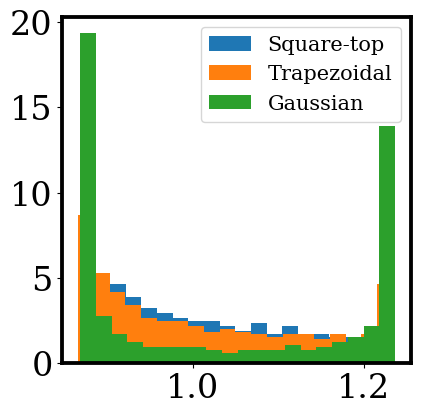

In [ ]:
plt.hist(np.array(EnK_01[0]),bins=20,density=True,label='Square-top')
plt.hist(np.array(EnK_01[1]),bins=20,density=True,label='Trapezoidal')
plt.hist(np.array(EnK_01[2]),bins=20,density=True,label='Gaussian')
plt.legend(fontsize=15)

## k = 0.5

In [ ]:
fp = 1
kp = .5
Dt = kp/M

In [ ]:
position_mult = []
velocity_mult = []
E_field_mult = []
for i in range(3):
    Mass  = mass_mult[i]
    Charge = charge_mult[i]
    Params_sys = [Dt,Mass,Charge,V0,d]
    res_ = Simulation(2,Params_sys,ini_conds,iterations)
    position_mult.append(res_[0])
    velocity_mult.append(res_[1])
    E_field_mult.append(res_[2])

### at t = $2T_0$

In [ ]:
pos_ = [1]
EnK_05 = []
timeA = []

for v in range(3):  # Loop over v values 0, 1, 2
    K = []
    for p in pos_:
        for i in range(position_mult[v].shape[1]):
            for j in range(1950):
                if position_mult[v][j][i] >= p:
                    K.append(velocity_mult[v][j][i] ** 2)
                    break
    EnK_05.append(K)

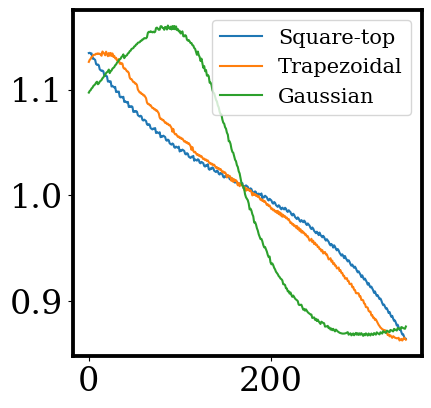

In [ ]:
plt.plot(EnK_05[0],label='Square-top')
plt.plot(EnK_05[1],label='Trapezoidal')
plt.plot(EnK_05[2],label='Gaussian')
plt.legend(fontsize=15)

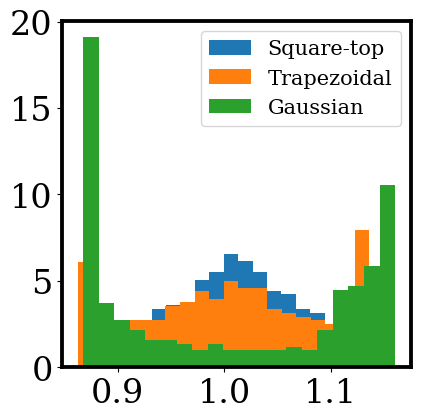

In [ ]:
plt.hist(np.array(EnK_05[0]),bins=20,density=True,label='Square-top')
plt.hist(np.array(EnK_05[1]),bins=20,density=True,label='Trapezoidal')
plt.hist(np.array(EnK_05[2]),bins=20,density=True,label='Gaussian')
plt.legend(fontsize=15)

## k = 1

In [ ]:
fp = 1
kp = 1
Dt = kp/M

In [ ]:
position_mult = []
velocity_mult = []
E_field_mult = []
for i in range(3):
    Mass  = mass_mult[i]
    Charge = charge_mult[i]
    Params_sys = [Dt,Mass,Charge,V0,d]
    res_ = Simulation(2,Params_sys,ini_conds,iterations)
    position_mult.append(res_[0])
    velocity_mult.append(res_[1])
    E_field_mult.append(res_[2])

### at t = $2T_0$

In [ ]:
pos_ = [1]
EnK_1 = []
timeA = []

for v in range(3):  # Loop over v values 0, 1, 2
    K = []
    for p in pos_:
        for i in range(position_mult[v].shape[1]):
            for j in range(1950):
                if position_mult[v][j][i] >= p:
                    K.append(velocity_mult[v][j][i] ** 2)
                    break
    EnK_1.append(K)

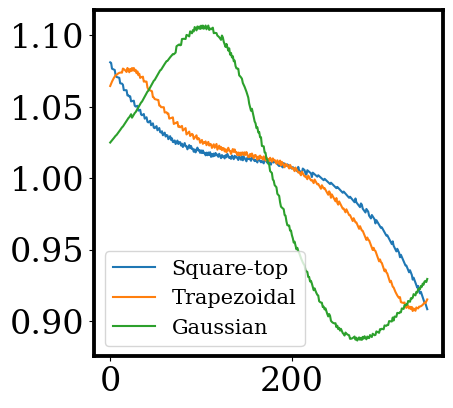

In [ ]:
plt.plot(EnK_1[0],label='Square-top')
plt.plot(EnK_1[1],label='Trapezoidal')
plt.plot(EnK_1[2],label='Gaussian')
plt.legend(fontsize=15)

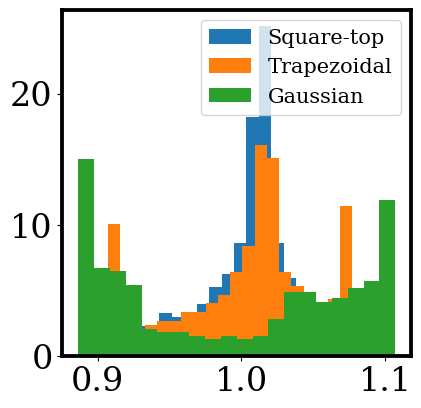

In [ ]:
plt.hist(np.array(EnK_1[0]),bins=20,density=True,label='Square-top')
plt.hist(np.array(EnK_1[1]),bins=20,density=True,label='Trapezoidal')
plt.hist(np.array(EnK_1[2]),bins=20,density=True,label='Gaussian')
plt.legend(fontsize=15)